In [6]:
import sys

assert sys.version_info >= (3, 7)

In [7]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [9]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


In [11]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'.\\datasets\\ridership.tgz'

In [12]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [13]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


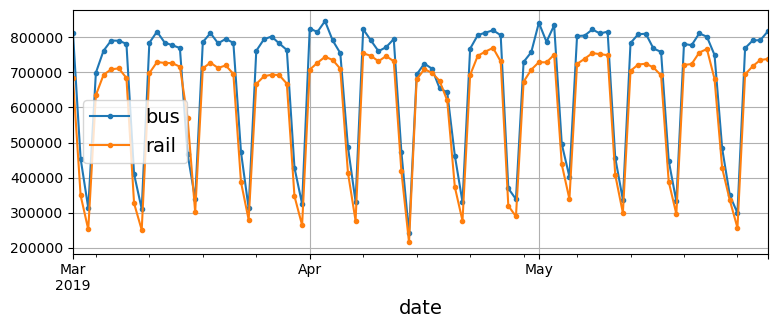

In [14]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

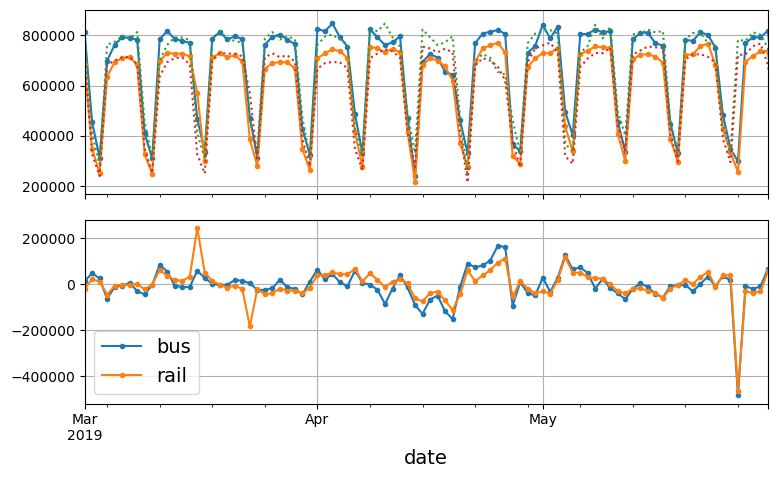

In [15]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [16]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [17]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [18]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

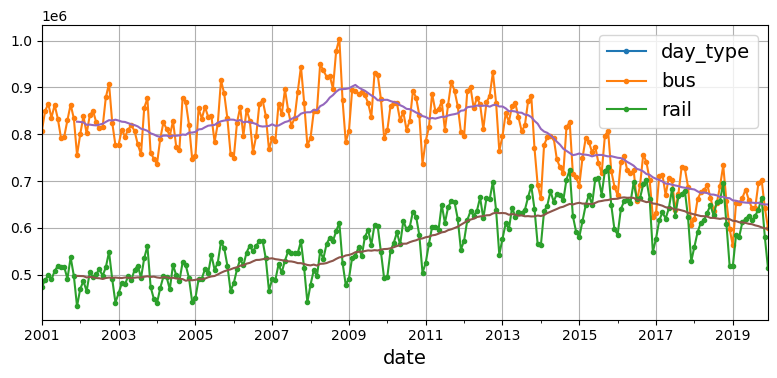

In [19]:
period = slice("2001", "2019")
df = df.apply(pd.to_numeric, errors='coerce') #added
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

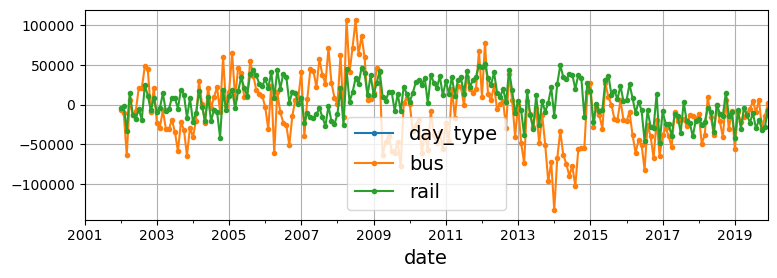

In [20]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

In [21]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [22]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [23]:
y_pred[0]  # ARIMA forecast

427758.6264070888

In [24]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [25]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [26]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [27]:
mae

32040.720098030044

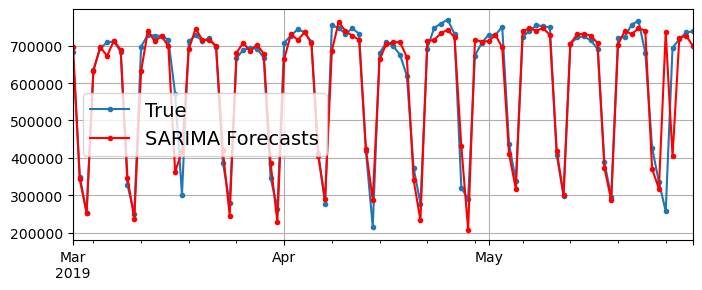

In [28]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

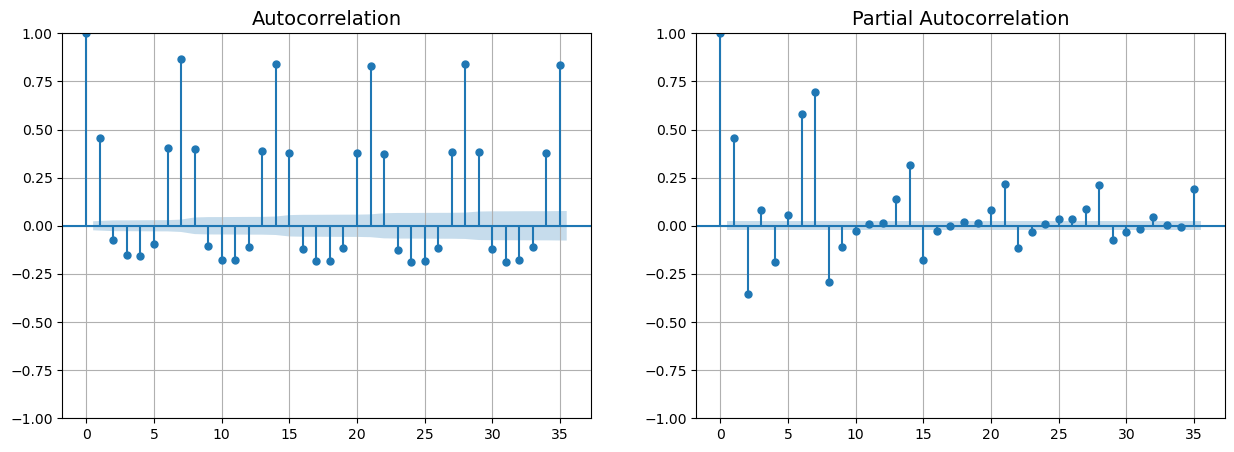

In [29]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [30]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [31]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [32]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [33]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

In [34]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [35]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [36]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


C:\Users\ishup\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1364 - mae: 0.4174 - val_loss: 0.0168 - val_mae: 0.1517
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0162 - mae: 0.1435 - val_loss: 0.0074 - val_mae: 0.0918
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - mae: 0.1009 - val_loss: 0.0083 - val_mae: 0.1002
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mae: 0.0879 - val_loss: 0.0063 - val_mae: 0.0840
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0893 - val_loss: 0.0060 - val_mae: 0.0810
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - mae: 0.0792 - val_loss: 0.0057 - val_mae: 0.0792
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0788 - val_loss: 0.0054 - val_mae: 0.0766
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mae: 0.0834 - val_loss: 0.0053 - val_mae: 0.0770
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - mae: 0.

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0538 - val_loss: 0.0024 - val_mae: 0.0437
Epoch 56/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0484 - val_loss: 0.0028 - val_mae: 0.0470
Epoch 57/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0575 - val_loss: 0.0025 - val_mae: 0.0472
Epoch 58/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0464 - val_loss: 0.0024 - val_mae: 0.0441
Epoch 59/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0508 - val_loss: 0.0024 - val_mae: 0.0433
Epoch 60/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0495 - val_loss: 0.0025 - val_mae: 0.0428
Epoch 61/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0479 - val_loss: 0.0027 - val_mae: 0.0446
Epoch 62/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - mae: 0.0514 - val_loss: 0.0023 - val_mae: 0.0421
Epoch 63/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - 

Epoch 109/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0438 - val_loss: 0.0023 - val_mae: 0.0393
Epoch 110/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0024 - val_mae: 0.0392
Epoch 111/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mae: 0.0432 - val_loss: 0.0023 - val_mae: 0.0375
Epoch 112/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.0460 - val_loss: 0.0024 - val_mae: 0.0389
Epoch 113/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - mae: 0.0458 - val_loss: 0.0025 - val_mae: 0.0406
Epoch 114/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0479 - val_loss: 0.0024 - val_mae: 0.0423
Epoch 115/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0471 - val_loss: 0.0023 - val_mae: 0.0376
Epoch 116/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0023 - val_mae: 0.0376
Epoch 117/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

In [37]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mae: 0.0371  


36938.8572871685

In [38]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

C:\Users\ishup\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [40]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0598 - mae: 0.3055 - val_loss: 0.0117 - val_mae: 0.1165
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0123 - mae: 0.1259 - val_loss: 0.0119 - val_mae: 0.1152
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0121 - mae: 0.1257 - val_loss: 0.0115 - val_mae: 0.1162
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0112 - mae: 0.1230 - val_loss: 0.0114 - val_mae: 0.1160
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0114 - mae: 0.1238 - val_loss: 0.0114 - val_mae: 0.1158
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0108 - mae: 0.1209 - val_loss: 0.0114 - val_mae: 0.1154
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0112 - mae: 0.1225 - val_loss: 0.0113 - val_mae: 0.1152
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0111 - mae: 0.1220 - val_loss: 0.0112 - val_mae: 0.1150
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - lo

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0107 - mae: 0.1161 - val_loss: 0.0103 - val_mae: 0.1045
Epoch 55/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0104 - mae: 0.1139 - val_loss: 0.0103 - val_mae: 0.1044
Epoch 56/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0102 - mae: 0.1131 - val_loss: 0.0103 - val_mae: 0.1043
Epoch 57/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0104 - mae: 0.1147 - val_loss: 0.0103 - val_mae: 0.1043
Epoch 58/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0105 - mae: 0.1146 - val_loss: 0.0103 - val_mae: 0.1041
Epoch 59/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0104 - mae: 0.1128 - val_loss: 0.0103 - val_mae: 0.1041
Epoch 60/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0105 - mae: 0.1144 - val_loss: 0.0103 - val_mae: 0.1040
Epoch 61/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0100 - mae: 0.1111 - val_loss: 0.0103 - val_mae: 0.1040
Epoch 62/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0108 - mae: 0.1161 - val_loss: 0.0103 - val_mae: 0.1031
Epoch 108/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0108 - mae: 0.1156 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 109/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0107 - mae: 0.1147 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 110/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0105 - mae: 0.1123 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 111/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0106 - mae: 0.1145 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 112/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0107 - mae: 0.1151 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 113/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0106 - mae: 0.1146 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 114/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0105 - mae: 0.1137 - val_loss: 0.0103 - val_mae: 0.1030
Epoch 115/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0106 - mae: 0.1146 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 161/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0104 - mae: 0.1140 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 162/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0106 - mae: 0.1141 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 163/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0107 - mae: 0.1141 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 164/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0104 - mae: 0.1129 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 165/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0099 - mae: 0.1109 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 166/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0100 - mae: 0.1121 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 167/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0106 - mae: 0.1137 - val_loss: 0.0103 - val_mae: 0.1029
Epoch 168/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 

102810.77027320862

In [41]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [42]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0737 - mae: 0.3084 - val_loss: 0.0052 - val_mae: 0.0796
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0062 - mae: 0.0839 - val_loss: 0.0032 - val_mae: 0.0574
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0043 - mae: 0.0616 - val_loss: 0.0029 - val_mae: 0.0509
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0044 - mae: 0.0565 - val_loss: 0.0021 - val_mae: 0.0341
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035 - mae: 0.0489 - val_loss: 0.0020 - val_mae: 0.0336
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0029 - mae: 0.0471 - val_loss: 0.0020 - val_mae: 0.0337
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0026 - val_mae: 0.0446
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0024 - val_mae: 0.0393
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - lo

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027 - mae: 0.0427 - val_loss: 0.0020 - val_mae: 0.0378
Epoch 55/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028 - mae: 0.0410 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 56/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028 - mae: 0.0414 - val_loss: 0.0020 - val_mae: 0.0356
Epoch 57/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024 - mae: 0.0398 - val_loss: 0.0020 - val_mae: 0.0370
Epoch 58/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024 - mae: 0.0405 - val_loss: 0.0019 - val_mae: 0.0321
Epoch 59/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0030 - mae: 0.0457 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 60/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - mae: 0.0378 - val_loss: 0.0024 - val_mae: 0.0430
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - mae: 0.0271    


29421.409592032433

In [43]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [44]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.1743 - mae: 0.4239 - val_loss: 0.0173 - val_mae: 0.1347
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0180 - mae: 0.1585 - val_loss: 0.0150 - val_mae: 0.1561
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0164 - mae: 0.1620 - val_loss: 0.0135 - val_mae: 0.1387
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0146 - mae: 0.1510 - val_loss: 0.0111 - val_mae: 0.1180
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0152 - mae: 0.1378 - val_loss: 0.0080 - val_mae: 0.1109
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0093 - mae: 0.1098 - val_loss: 0.0053 - val_mae: 0.0836
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0074 - mae: 0.0955 - val_loss: 0.0055 - val_mae: 0.0910
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0064 - mae: 0.0879 - val_loss: 0.0037 - val_mae: 0.0645
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - l

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0029 - mae: 0.0474 - val_loss: 0.0018 - val_mae: 0.0332
Epoch 55/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0033 - mae: 0.0501 - val_loss: 0.0021 - val_mae: 0.0398
Epoch 56/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0030 - mae: 0.0451 - val_loss: 0.0019 - val_mae: 0.0353
Epoch 57/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0037 - mae: 0.0483 - val_loss: 0.0017 - val_mae: 0.0309
Epoch 58/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0028 - mae: 0.0427 - val_loss: 0.0024 - val_mae: 0.0451
Epoch 59/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0031 - mae: 0.0467 - val_loss: 0.0017 - val_mae: 0.0294
Epoch 60/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0033 - mae: 0.0472 - val_loss: 0.0017 - val_mae: 0.0312
Epoch 61/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0031 - mae: 0.0446 - val_loss: 0.0017 - val_mae: 0.0313
Epoch 62/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 

29074.493795633316

In [56]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [57]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [58]:

tf.random.set_seed(42)  # extra code – ensures reproducibility
train_data = mulvar_train.to_numpy()
valid_data = mulvar_valid.to_numpy()

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_data,  # use all 5 columns as input
    targets=train_data[seq_length:, 1],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid_data,
    targets=valid_data[seq_length:, 1], 
    sequence_length=seq_length,
    batch_size=32
)

In [59]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, train_data.shape[1])),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [60]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan 


nan

In [62]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
batch_size = 32

train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=batch_size
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, mulvar_train.shape[1])),  # Adjust input shape
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: nan - mae: nan 


nan

In [63]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [66]:
import numpy as np
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    mae = np.nan_to_num(mae, nan=0.0)
    print(name, int(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
bus 0
rail 0


In [67]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


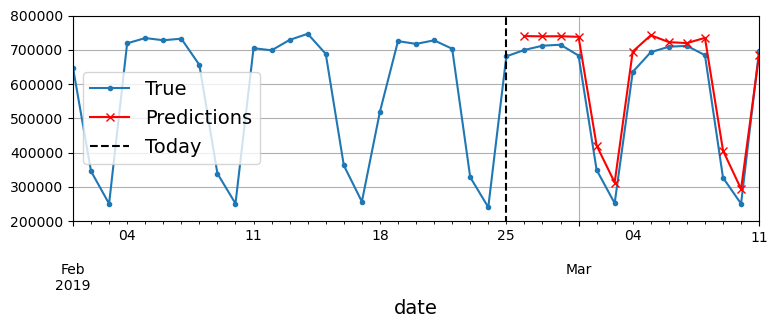

In [68]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()


In [69]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [70]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

C:\Users\ishup\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [71]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/20


ValueError: Exception encountered when calling SimpleRNNCell.call().

[1mDimensions must be equal, but are 3 and 5 for '{{node sequential_13_1/simple_rnn_14_1/simple_rnn_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_13_1/simple_rnn_14_1/strided_slice_4, sequential_13_1/simple_rnn_14_1/simple_rnn_cell_1/Cast/ReadVariableOp)' with input shapes: [?,3], [5,32].[0m

Arguments received by SimpleRNNCell.call():
  • sequence=tf.Tensor(shape=(None, 3), dtype=float32)
  • states=('tf.Tensor(shape=(None, 32), dtype=float32)',)
  • training=True

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [ ]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [ ]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [ ]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

# exercises


In [ ]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [ ]:
train_files

In [ ]:
eval_files

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)
